In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-05-23 19:36:43.884977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748029004.079762      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748029004.137358      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Defining Paths

In [2]:
train_dir = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train'
test_dir = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test'
train_csv_path = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv'
test_csv_path = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv'

In [3]:
# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_ids_df = pd.read_csv(test_csv_path)

In [7]:
train_df.tail()

,image_id,label
1217,img_9ae546bd.jpg,1
1218,img_6e0b1b7c.jpg,1
1219,img_5c4372f8.jpg,1
1220,img_6f5bf9d2.jpg,1
1221,img_c14dbbd0.jpg,1


# Some EDA

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


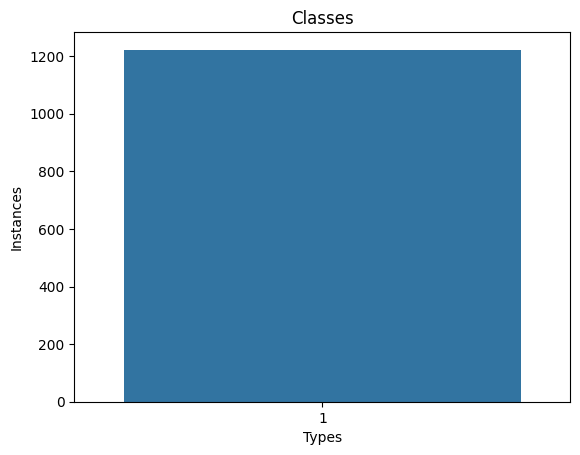

In [6]:
sns.barplot(x=train_df['label'].unique(), y=train_df['label'].value_counts())
plt.title("Classes")
plt.xlabel("Types")
plt.ylabel("Instances")
plt.show()

### **This is interesting just one class, lets check what is it**

In [8]:
from PIL import Image

In [11]:
def visualise(num):
    image_file = train_df['image_id'].iloc[num]
    image_path = os.path.join(train_dir, image_file)
    
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(num)
    plt.show()

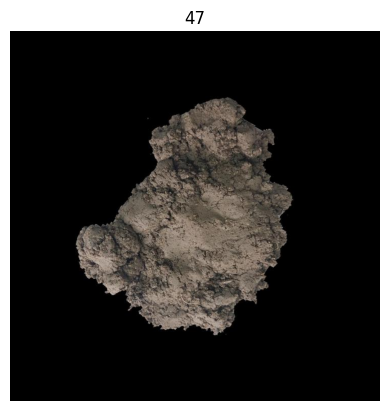

In [14]:
visualise(47)

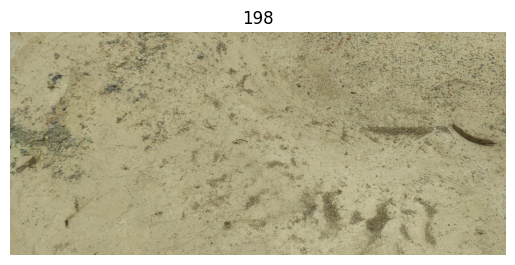

In [15]:
visualise(198)

### **All are soil, we cannot use supervised deep learning, we shall go for unsupervised deep learning**

# Load Data

In [20]:

def load_data(train_dir, train_csv_path, image_size=(128, 128)):
    # Read labels CSV
    train_df = pd.read_csv(train_csv_path)
    
    images = []
    labels = []

    for _, row in train_df.iterrows():
        img_id = row['image_id']
        label = row['label']

        img_path = os.path.join(train_dir, img_id)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0  # Normalize to [0,1]
            images.append(img)
            labels.append(label)
        else:
            print(f"Image not found: {img_path}")
    
    X = np.array(images, dtype=np.float32)
    y = np.array(labels)
    return X, y


In [21]:
X_train, y_train = load_data(train_dir, train_csv_path, image_size=(128, 128))
print(X_train.shape, y_train.shape)

(1222, 128, 128, 3) (1222,)


# We are doing transferlearning using an autoencoder

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (128, 128, 3)
inputs = tf.keras.Input(shape=input_shape)

# Encoder: MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
encoded = base_model(inputs)  # Output shape: (4, 4, 1280)

# Decoder: Upsample back to 128x128
x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(encoded)  # 8x8
x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)        # 16x16
x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)        # 32x32
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)         # 64x64
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)         # 128x128
decoded = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)  # Output shape: 128x128x3

autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [28]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 8, 8, 512)           │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,724,803 (37.10 MB)

 Trainable params: 7,466,819 (28.48 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',     # What to watch
    patience=5,             # Wait 5 epochs with no improvement
    restore_best_weights=True  # Roll back to best weights
)


In [30]:

history = autoencoder.fit(
    X_train, X_train,
    validation_split=0.2,   # Split part of training data for validation
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    shuffle=True
)

Epoch 1/100


I0000 00:00:1748030386.660374     115 service.cc:148] XLA service 0x7deb50004110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748030386.661231     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748030387.700687     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0714

I0000 00:00:1748030393.873110     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 448ms/step - loss: 0.0625 - val_loss: 0.0956
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0332 - val_loss: 0.0610
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0234 - val_loss: 0.0743
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0197 - val_loss: 0.0660
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0180 - val_loss: 0.0457
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0162 - val_loss: 0.0561
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0147 - val_loss: 0.0516
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0145 - val_loss: 0.0580
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0142 - val_loss: 0.0514
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0138 - val_loss: 0.0515


# Plotting the training loss

In [31]:
def plot_history(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

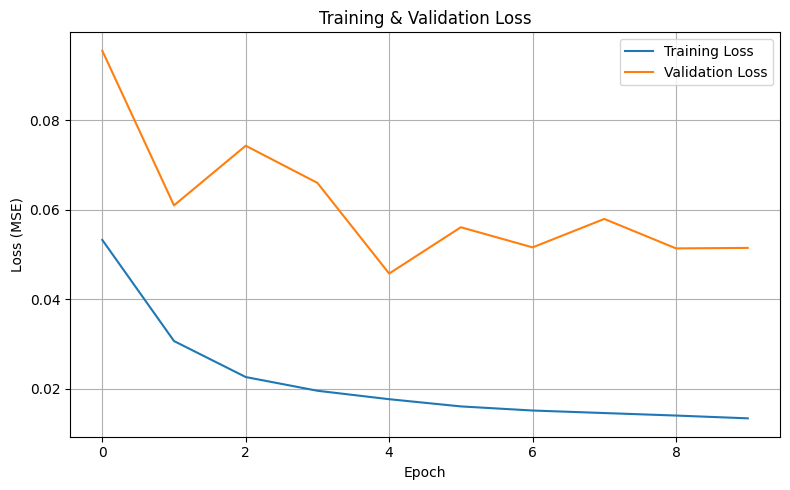

In [32]:
plot_history(history)

### Model seems overfit

# Some tests and classifications

In [33]:
def test_and_classify(autoencoder, X_test, threshold, n=5):

    decoded_imgs = autoencoder.predict(X_test[:n])
    
    plt.figure(figsize=(14, 5))
    for i in range(n):
        # Reconstruction error per pixel, then mean error scalar
        error_map = np.mean((X_test[i] - decoded_imgs[i]) ** 2, axis=-1)
        error_scalar = np.mean(error_map)
        
        # Classification based on threshold
        predicted_label = 1 if error_scalar <= threshold else 0
        
        # Plot original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(X_test[i])
        plt.title("Original")
        plt.axis("off")
        
        # Plot reconstructed
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
        # Plot error heatmap
        ax = plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(error_map, cmap='hot')
        plt.title("Error Map")
        plt.axis("off")
        
        # Plot predicted label
        ax = plt.subplot(4, n, i + 1 + 3 * n)
        plt.text(0.5, 0.5, f'Predicted: {predicted_label}', fontsize=14, ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

***Finding a threshold***

In [34]:
decoded_train = autoencoder.predict(X_train)
train_errors = np.mean(np.mean((X_train - decoded_train) ** 2, axis=-1), axis=-1)
threshold = np.percentile(train_errors, 95)
print("Threshold:", threshold)

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step
Threshold: 0.0610525906085968


## Loading test data

In [39]:
def load_test_images(test_dir, test_ids_df, image_size=(128, 128)):
    """
    Load test images given a directory and a DataFrame with image ids.

    Args:
        test_dir (str): Path to test images folder.
        test_ids_df (pd.DataFrame): DataFrame with a column 'id' containing image filenames (without extension).
        image_size (tuple): Desired image size, e.g. (128, 128).

    Returns:
        np.ndarray: Array of normalized images with shape (num_images, height, width, channels).
    """
    images = []
    for img_id in test_ids_df['image_id']:
        img_path = os.path.join(test_dir, f"{img_id}") 
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0  # normalize to [0,1]
            images.append(img)
        else:
            print(f"Warning: Image not found - {img_path}")
    return np.array(images, dtype=np.float32)

In [40]:
X_test = load_test_images(test_dir, test_ids_df, image_size=(128, 128))
print("Loaded test images shape:", X_test.shape)

Loaded test images shape: (967, 128, 128, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


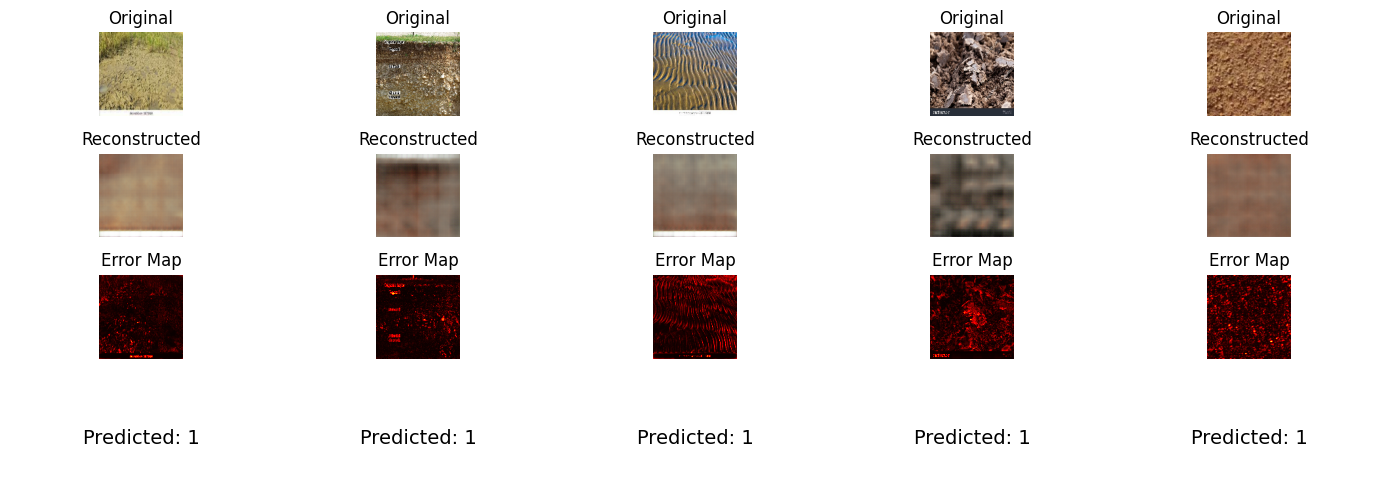

In [41]:
test_and_classify(autoencoder, X_test, threshold, n=5)

# Prediction Function

In [44]:

def get_test_predictions(autoencoder, X_test, threshold):
    """
    Generate soil/not-soil predictions for all test images based on reconstruction error.

    Args:
      autoencoder: trained autoencoder model
      X_test (np.ndarray): test images normalized [0,1], shape (num_samples, H, W, C)
      threshold (float): reconstruction error threshold for classification

    Returns:
      List[int]: list of predicted labels (1 for soil, 0 for not soil)
    """
    decoded_imgs = autoencoder.predict(X_test)
    
    # Compute mean squared error per image (average over height, width, channels)
    # axis=(1,2,3) means average over H, W, C for each sample
    errors = np.mean((X_test - decoded_imgs) ** 2, axis=(1,2,3))
    
    # Classify using threshold (now error is scalar per image)
    predictions = [1 if error <= threshold else 0 for error in errors]
    return predictions


# Custom Threshold optimization (Assuming equivalence of test classes)

In [89]:
def optimizeThreshold():
    th = []
    diff = []
    thresh = 0.0001
    for i in range(100):
        thresh += 0.0001 * i
        th.append(thresh)
        pred = get_test_predictions(autoencoder, X_test, thresh)
        
        values, counts = np.unique(pred, return_counts=True)

        if len(counts) == 1:
            # Only one class exists in predictions
            difference = counts[0]  # maximal imbalance
        else:
            # Difference in number of predicted samples
            difference = abs(counts[0] - counts[1])
        
        diff.append(difference)
        
    return th, diff

In [90]:
th,diff=optimizeThreshold()

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


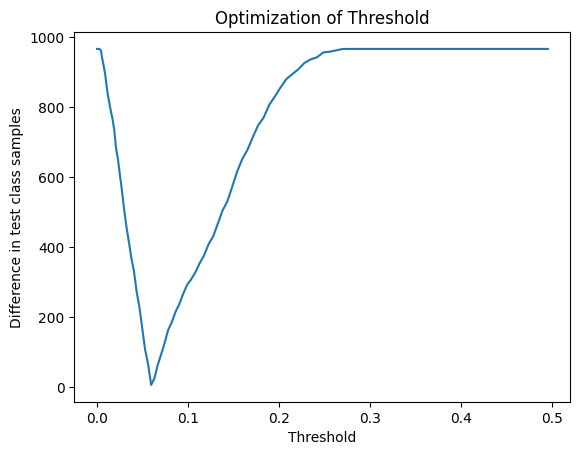

In [94]:
plt.plot(th,diff)
plt.xlabel("Threshold")
plt.ylabel("Difference in test class samples")
plt.title("Optimization of Threshold")
plt.show()

In [98]:
threshold_index=min_index = np.argmin(diff)
threshold_index

34

In [100]:
threshold_new=th[34]
threshold_new

0.0596

In [101]:
predictions = get_test_predictions(autoencoder, X_test, threshold_new)
print(predictions)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,

In [112]:
np.unique(predictions, return_counts=True)

(array([0, 1]), array([487, 480]))

# Making and Saving CSV

In [102]:
test_ids_df['label']=predictions

In [103]:
test_ids_df

,image_id,label
0,6595f1266325552489c7d1635fafb88f.jpg,1
1,4b614841803d5448b59e2c6ca74ea664.jpg,1
2,ca30e008692a50638b43d944f46245c8.jpg,1
3,6a9046a219425f7599729be627df1c1a.jpg,1
4,97c1e0276d2d5c2f88dddbc87357611e.jpg,1
...,...,...
962,0a7bf5babc365ca6b10dae582661988e.jpg,0
963,1bd2aef3edff5434891801e77975f533.jpg,1
964,86522810b6045b2f9ccdb2f9027aadf8.jpg,1
965,687517ac929e59428f0c20de4a994b5f.jpg,1


In [106]:
test_ids_df.to_csv('/kaggle/working/Submissionfilenew.csv', index=False)

In [49]:
autoencoder.save('/kaggle/working/Autoencoder.h5')

In [61]:
def visualiseTest(num):
    image_file = test_ids_df['image_id'].iloc[num]
    image_path = os.path.join(test_dir, image_file)
    
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Soil" if test_ids_df['label'].iloc[num]==1 else "Not Soil")
    plt.show()

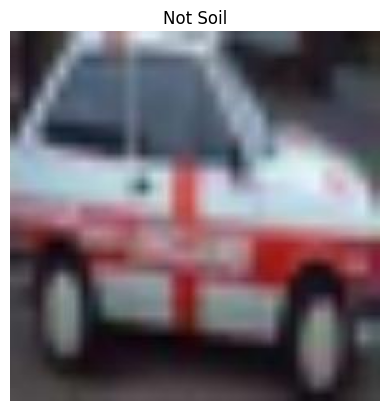

In [108]:
visualiseTest(-5)

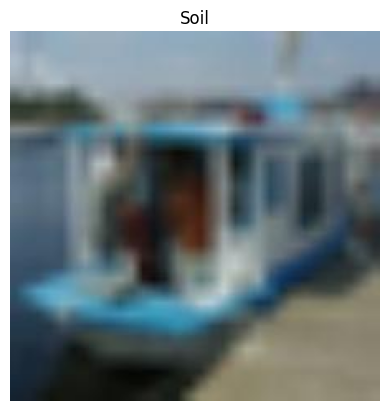

In [109]:
visualiseTest(-7)

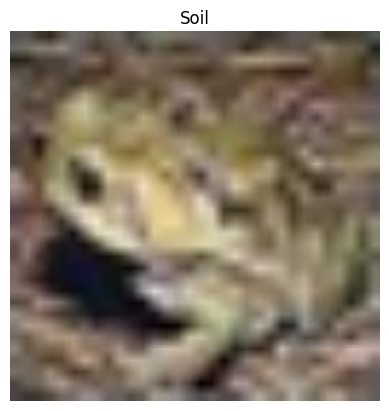

In [110]:
visualiseTest(-2)